##Bevezetés##

**Face emotion recognition convolutional neural network - Mátyás Tóth**

**Key words:** neural networks; input, output and hidden layers, activation function, connections and weights in neural networks, feedforward neural networks, epoch, stochastic gradient method, weight update, error propagation

In the following, I will generate a simple facial emotion smoothing convolutional neural network using the TensorFlow and Keras Deep Learning libraries. The data used for this is available from the following link:
https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset

To create the model, I call the following Python libraries.

In [ ]:
# Libraries for neural network representation, vectors matrices and stastics operations.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Libraries used for Deep Learning for image processing, data generation, model building, model optimization and model performance measurement.

from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from sklearn.metrics import classification_report, confusion_matrix

Embed Google Drive in the Google Colab runtime environment and load the package needed to read the .zip file:

In [ ]:
from google.colab import drive
import zipfile
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


A fájl betöltése és kicsomagolása:

In [ ]:
!unzip gdrive/My\ Drive/data_science_refrencia/Python/archive.zip > /dev/null

replace images/images/train/angry/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


Determine image size and path:

In [ ]:
picture_size = 48
folder_path = "/content/images/images/"

I draw 9 sad images and resize them to 48x48 mm using a path called in a for loop.

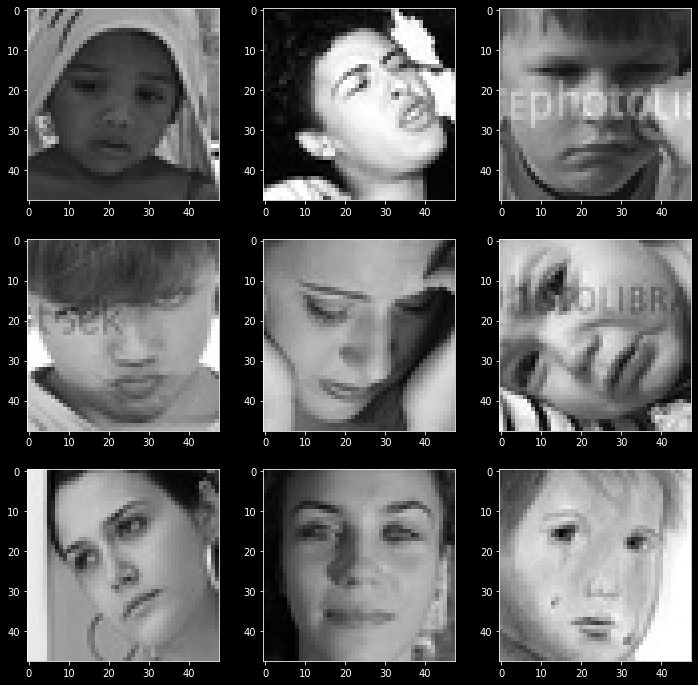

In [ ]:
expression = 'sad'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+ os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)
plt.show()

##Modell építés##

A követező cellában meghatározom a batch size, tehát a model tréningelése során keresztül propagált mintaelemszámot - többszöri tesztelés után (32,64) a nagyobb batch size mellett döntöttem, mivel pontosabb modelt ereményezett.

A TensorFlow ImageDataGenerator() függvényével létrehoztam tréning és teszt adathalmazt - az erre szolgáló folderek meghívásával -, amelyekben beállítottam a képméretet, a színskálát, a klasszifikáció módját, valamint hogy összekeverje-e a képeket.

In [ ]:
batch_size  = 128

datagen_train  = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"validation",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In the following, I will create a convolutional neural network by calling the necessary optimizers from the TensorFlow library, setting the number of output categories, and then building the neural network layer by layer using the Sequential() function.

In the middle layers of the model, we use ReLu (rectified linear unit) activation function to determine the inputs to the neurons and their outputs. The exception to this is the last layer, where I use a 'softmax' function.

The parameters of the convolution layers are as follows:
1. we specify the layers (64) and the size (3x3) of the convolution kernel. We apply zero padding - padding = 'same' - to the convolution (so the image size does not change after the convolution), and then we set the input image size.
The layers of the kernel are doubled up to the third layer, and then merged with a fourth layer of the same size. It is important to note that the parameters of the convolution kernel are arbitrary.
2. BatchNormalization(): the pseudo-average and variance of the output of the neurons are kept close to zero to avoid covariance between batches.
3. activation function: ReLu - f(x) = max(0,x) - if the input is negative then the output is 0, if the input is positive then the output is positive. The backpropagation algorithm is essential for learning the network. The algorithm tries to find the global minimum based on the stochastic gradient descent, but this can decrease drastically as the input layer is approached - so-called vanishing gradients. If the gradient is negative, ReLu does not protect against the problem, but it is still more efficient than Tanh or Sigmoid.
4. The MaxPooling2D function reduces the spatial dimension by the value maxima of the channels that make up the image after applying a convolution filter. The size of the resulting 'image extract' is also defined (2x2).
5. In convolutional neural networks, for more efficient computation, we inactivate/remove a part of the neurons after each layer, since the individual neurons do not participate with the same weight in the fading of the network profile.
This is done with the Dropout() function, where 0.25-d of the neurons are inactivated.

Since after a convolution we obtain a 4-dimensional tensor (channels x height x width x batch size ), we are forced to make it one-dimensional to obtain a simple categorical probability. This is done by the flatten() function.

After the smoothness, there are two fully bound intermediate layers with 512 neurons, followed by the output layer where we use a 'softmax' activation function to get the probability of belonging to a category ('sad', 'happy' etc. ).
softmax: sigma(Z)i = e^Zi/sum(K(j=1))*e^Zi

Finally, we set up the optimizer, which in our case is Adam (adaptive movement estimation), which behaves efficiently on large data sets.

We define the learning rate, which in our case will be very small - 0.0001 - but this avoids the problem that the model might skip over important parameter spaces due to learning too fast.

For the performance of the model, we are interested in the Loss function, for which we use a categorical cross entropy (since the categories are mutually exclusive) and we are also interested in the accuracy of the model.

In [ ]:
from tensorflow.keras.optimizers import Adam,SGD,RMSprop


no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))

opt = Adam(learning_rate = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

**Plotting:**
In the following cell, the model is plotted for ease of interpretation. The necessary parameters for this will be the specified file format, the exact display of the layers and the neurons in them, the display of the data types, the display of the layer names and the top-down display. The other parameters are left as default.

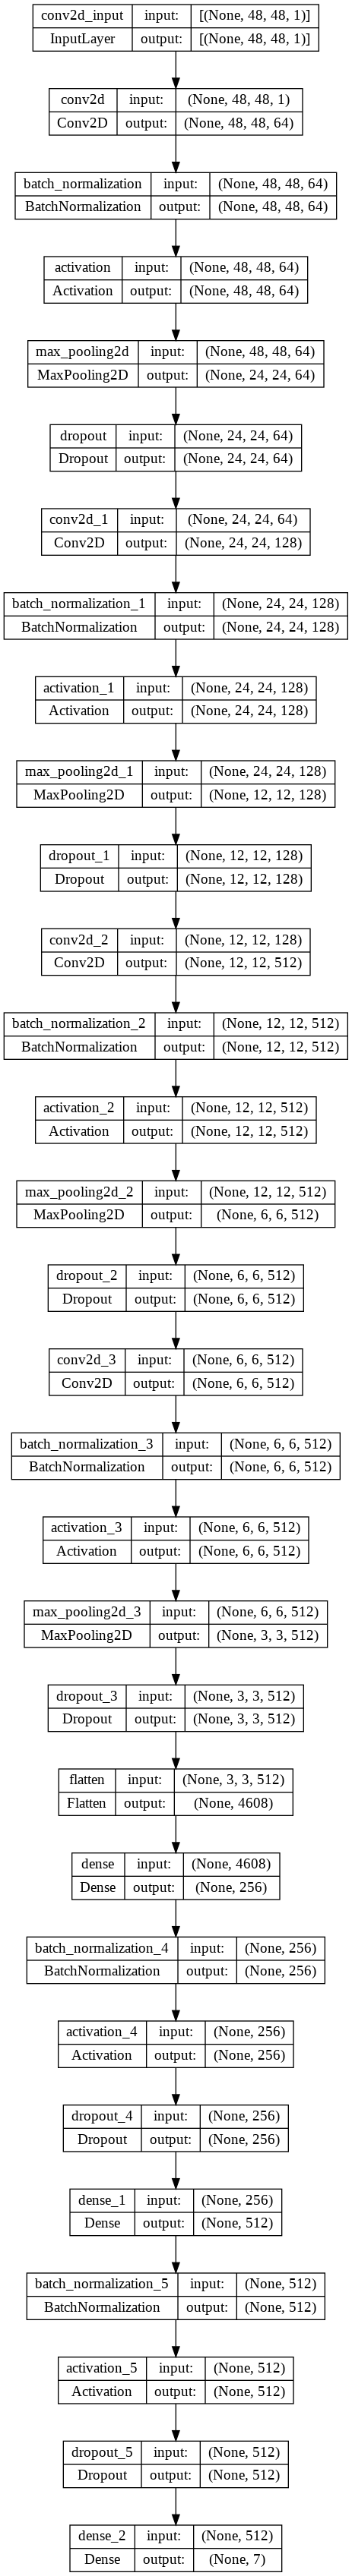

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

In the next cell I define the functions and parameters needed to train the model.

checkpoint = ModelCheckpoint(): the parameters of the best performing model (e.g. weights between neurons) are saved.

early_stopping = EarlyStopping(): The EarlyStopping function stops further training of the model for certain observed parameters, if they reach the desired values, to avoid overfitting.
An example of such an observed parameter is validation loss, which decreases as the model is trained, but if this decrease stops, the training stops.

reduce_learningrate = ReduceLROnplateau(): Automatically starts to reduce the learning rate when the model shows no further progress based on the observation of the 'val_loss' parameter shown above.

The functions shown above have the following options:
- min_delta: during training, the model continuously optimizes itself and when the set low threshold is reached, it always runs again. A low number is recommended.
- patience: if the training rate is lowered by ReducLROnPlateau, this setting can be used to control the number of times (epoch) the model should run when the learning rate is lowered, with the important proviso that the model is no longer evolving.
- verbose: Whether to communicate any changes to the model.
- restore_best_weights: Whether to restore the best weights = True.
- factor: the factor by which the ReduceLROnPlateau function will reduce the learning rate.

Finally, I'll compile a list of variables for the functions described above for later use, then define the number of trials (epoch), and finally call the parameters again with model.compile, as in the definition of model.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#Stopping training when a monitored metric has stopped improving.
early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 10

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001),
              metrics=['accuracy'])


The model.fit_generator function is the suffix that we need to specify before running the model. The model.fit_generator, unlike the model.fit Keras function, is better at handling memory-intensive processes, which are particularly important for a convolutional neural network.
Within this function I use the bounding parameters:
- in the generator it is necessary to call the data set to train the model
- steps_per_epoch: the size of the training dataset without residuals is divided by the batch size of the training dataset to get the number of steps (for each epoch)
- the size of the epochs is also called
- in validation_steps, we call the same as in steps_per_epoch, this time via the test dataset
- in callbacks, we call the functions defined in the previous cell to run the model

In [ ]:
history = model.fit_generator(generator=train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                callbacks=callbacks_list
                                )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
225/225 [==============================] - ETA: 0s - loss: 2.0134 - accuracy: 0.2371

225/225 [==============================] - 1539s 7s/step - loss: 2.0134 - accuracy: 0.2371 - val_loss: 1.7335 - val_accuracy: 0.2926 - lr: 1.0000e-04
Epoch 2/10
225/225 [==============================] - ETA: 0s - loss: 1.8277 - accuracy: 0.2967

225/225 [==============================] - 1518s 7s/step - loss: 1.8277 - accuracy: 0.2967 - val_loss: 1.6808 - val_accuracy: 0.3516 - lr: 1.0000e-04
Epoch 3/10
225/225 [==============================] - ETA: 0s - loss: 1.7161 - accuracy: 0.3393

225/225 [==============================] - 1521s 7s/step - loss: 1.7161 - accuracy: 0.3393 - val_loss: 1.6229 - val_accuracy: 0.3801 - lr: 1.0000e-04
Epoch 4/10
225/225 [==============================] - ETA: 0s - loss: 1.6358 - accuracy: 0.3706

225/225 [==============================] - 1528s 7s/step - loss: 1.6358 - accuracy: 0.3706 - val_loss: 1.6037 - val_accuracy: 0.4036 - lr: 1.0000e-04
Epoch 5/10
225/225 [==============================] - ETA: 0s - loss: 1.5800 - accuracy: 0.3888

225/225 [==============================] - 1535s 7s/step - loss: 1.5800 - accuracy: 0.3888 - val_loss: 1.5379 - val_accuracy: 0.4172 - lr: 1.0000e-04
Epoch 6/10
225/225 [==============================] - ETA: 0s - loss: 1.5253 - accuracy: 0.4101

225/225 [==============================] - 1532s 7s/step - loss: 1.5253 - accuracy: 0.4101 - val_loss: 1.5987 - val_accuracy: 0.4097 - lr: 1.0000e-04
Epoch 7/10
225/225 [==============================] - ETA: 0s - loss: 1.4711 - accuracy: 0.4362

225/225 [==============================] - 1538s 7s/step - loss: 1.4711 - accuracy: 0.4362 - val_loss: 1.5437 - val_accuracy: 0.4267 - lr: 1.0000e-04
Epoch 8/10
225/225 [==============================] - ETA: 0s - loss: 1.4308 - accuracy: 0.4498

225/225 [==============================] - 1554s 7s/step - loss: 1.4308 - accuracy: 0.4498 - val_loss: 1.4001 - val_accuracy: 0.4719 - lr: 1.0000e-04
Epoch 9/10
225/225 [==============================] - ETA: 0s - loss: 1.3888 - accuracy: 0.4672

225/225 [==============================] - 1562s 7s/step - loss: 1.3888 - accuracy: 0.4672 - val_loss: 1.3293 - val_accuracy: 0.4940 - lr: 1.0000e-04
Epoch 10/10
225/225 [==============================] - ETA: 0s - loss: 1.3429 - accuracy: 0.4850

225/225 [==============================] - 1565s 7s/step - loss: 1.3429 - accuracy: 0.4850 - val_loss: 1.2853 - val_accuracy: 0.5051 - lr: 1.0000e-04


You can see that the training stopped at epoch 8.

For each epoch, the loss function and the accuracy value are plotted, but the exact measurement of this will be done later. At the same time, it can be seen that performance has improved gradually, so overall we should not expect too different a result - this would be relevant for over- or under-fitting.

##Model performance##

The next cell shows how the loss function has decreased and the accuracy has increased. To do this we set the background colour and then plot the loss function and the accuracy using the subplot command. In both cases we plot the trend line for the training and test data sets - these are shown in the legend.

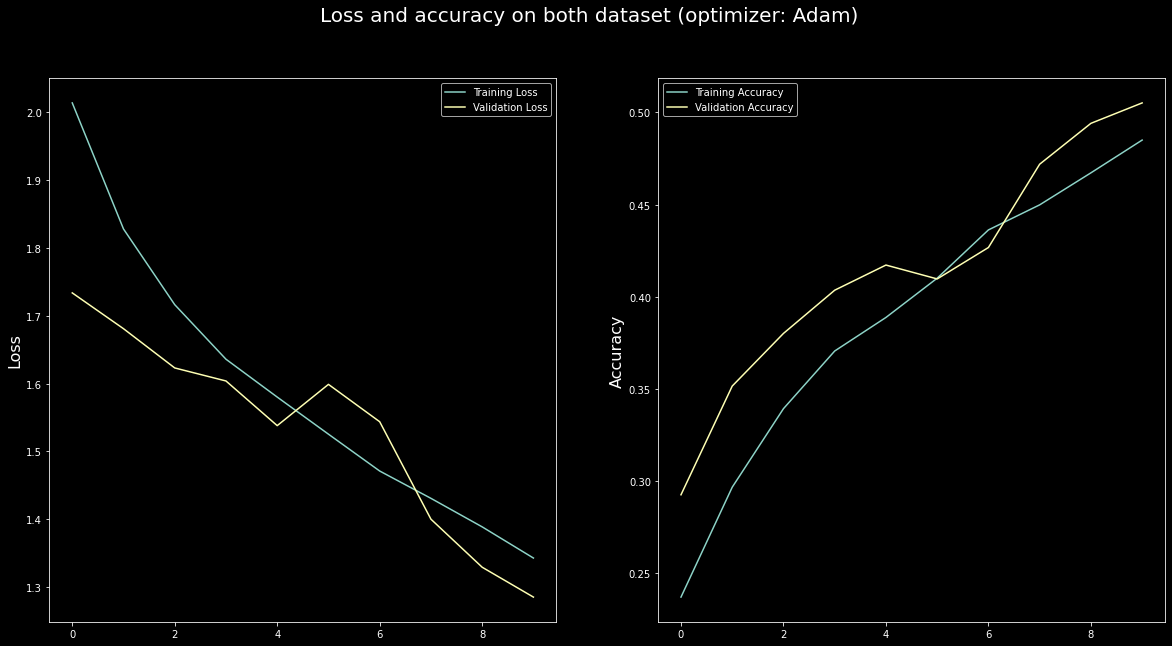

In [ ]:
#plotting graph to check accuracy and loss
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Loss and accuracy on both dataset (optimizer: Adam)', fontsize=20)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='upper left')
plt.show()

Save the model:

In [ ]:
model.save("face_emotion_recognition_Matyas_Toth.h5")

I call the precision and loss function on the test dataset using the following code. You can see that the model is slightly underfitted, but this is not significant. Overall, the values obtained from training and testing are similar, which means that the resulting model performance is slightly more accurate than average - approx: 0.5.

In [ ]:
print(f"Test accuracy = {model.evaluate(test_set ,batch_size=test_set.batch_size,steps=test_set.n // test_set.batch_size)[1]*100}%")

55/55 [==============================] - 87s 2s/step - loss: 1.2853 - accuracy: 0.5051
Test accuracy = 50.51136612892151%


In the next cell I plot the confusion matrix, which in this case I calculate based on the training dataset. Basically, the confusion matrix shows a cross-tabulation of true and predicted cases, showing true positives, false positives, true negatives and false negatives.

In my case, the confusion matrix shows only the number of items in each facial emotion category (according to the cross tabulation of true and predicted cases). Below this, the classification report is shown, where in turn the above categories by facial emotion are shown, as well as the accuracy, mean and weighted mean of the four categories listed.

Accordingly:
- Precision: number of true positive cases (TP/(TP+FP)).
- Recall: number of true positives between positive cases (TP/(FP+FN)).
- F1-Score: harmonic mean of precision and recall, i.e.
  (2(precision*recall))/(precision+recall).
- Support: in our case, this represents the number of cases that fit into a given facial emotion category.

226/226 [==============================] - 343s 2s/step
Confusion Matrix
[[ 198   29  245  982 1156  957  426]
 [  30    2   20  114  130   90   50]
 [ 190   30  213 1000 1190 1060  420]
 [ 365   42  444 1696 2045 1820  752]
 [ 262   38  265 1252 1355 1247  563]
 [ 259   33  281 1173 1367 1251  574]
 [ 163   24  193  781  922  800  322]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.05      0.07      3993
     disgust       0.01      0.00      0.01       436
        fear       0.13      0.05      0.07      4103
       happy       0.24      0.24      0.24      7164
     neutral       0.17      0.27      0.21      4982
         sad       0.17      0.25      0.21      4938
    surprise       0.10      0.10      0.10      3205

    accuracy                           0.17     28821
   macro avg       0.14      0.14      0.13     28821
weighted avg       0.17      0.17      0.16     28821



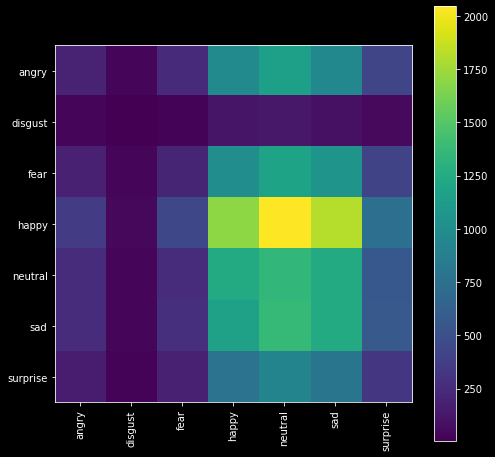

In [ ]:
y_pred = model.predict(train_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(train_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Finally, I call the confusion matrix and plot it for the test dataset.

56/56 [==============================] - 81s 1s/step
Confusion Matrix
[[ 181    6   65   95  285  291   37]
 [  15   14   12   10   27   30    3]
 [  56    2  165   77  277  310  131]
 [  27    1   25 1357  178  202   35]
 [  29    6   19  102  791  246   23]
 [  33    5   65   69  376  575   16]
 [   6    0   66   58  122   56  489]]
Classification Report
              precision    recall  f1-score   support

       angry       0.52      0.19      0.28       960
     disgust       0.41      0.13      0.19       111
        fear       0.40      0.16      0.23      1018
       happy       0.77      0.74      0.76      1825
     neutral       0.38      0.65      0.48      1216
         sad       0.34      0.50      0.40      1139
    surprise       0.67      0.61      0.64       797

    accuracy                           0.51      7066
   macro avg       0.50      0.43      0.43      7066
weighted avg       0.53      0.51      0.49      7066



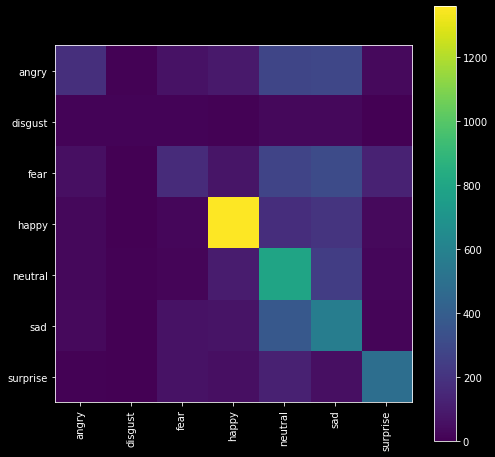

In [ ]:
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

To improve the model further, it is worth tuning some of the hyperparameters (learning rate, number of epochs, etc.) that affect the learning of the model, and to test how the model behaves when the convolution layers are given different parameters.